In [609]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from tqdm import tqdm

In [610]:
# defining parameters from Krishna/Jensen

k_Nin = 5.4 # min^{-1}
k_lin = 0.018 # min^{-1} 
k_t = 1.03 # mu * M^{-1} * min^{-1}
k_tl = 0.24 # min^{-1}
K_I = 0.035 # mu * M
K_N = 0.029 # mu * M
gamma_m = 0.017 # min^{-1}
alpha = 1.05 # mu * M^{-1} * min^{-1}
N_tot = 1.0 # mu * M
k_a = 0.24 # min^{-1}
k_i = 0.18 # min^{-1}
k_p = 0.036 # min^{-1}
k_A20 = 0.0018 # mu * M
IKK_tot = 2.0 # mu * M
A20 = 0.0026 # mu * M

In [664]:
# defining time
time = (0, 5000)

# defining constant to keep TNF>0
k = 0.5

# definerer startparameters
N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF_k = 1, 0.5, 0.5, 0.5, 0.5, k
y0 = [N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF_k]

In [665]:
# defining equations from Krishna/Jensen
def N_n_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dN_ndt = k_Nin * (N_tot - N_n) * K_I / (K_I + I) - k_lin * I * (N_n / (K_N + N_n))
    return dN_ndt

def I_m_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dI_mdt = k_t * (N_n**2) - gamma_m * I_m
    return dI_mdt

def I_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIdt = k_tl * I_m - alpha * IKK_a * (N_tot - N_n) * I / (K_I + I)
    return dIdt

def IKK_a_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_adt = k_a * TNF * (IKK_tot - IKK_a - IKK_i) - k_i * IKK_a
    return dIKK_adt

def IKK_i_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_idt = k_i * IKK_a - k_p * IKK_i * k_A20 / (k_A20 + A20 * TNF)
    return dIKK_idt


def system_nfkb(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = N_n_change(t, *y)
    dydt[1] = I_m_change(t, *y)
    dydt[2] = I_change(t, *y)
    dydt[3] = IKK_a_change(t, *y)
    dydt[4] = IKK_i_change(t, *y)
    return dydt

In [666]:
# simulating with constant TNF
simulation = solve_ivp(system_nfkb, time, y0, method='RK45', max_step=1)

# unpacking simulation
t_trans, N_n_trans, I_m_trans, I_trans, IKK_a_trans, IKK_i_trans = simulation["t"], simulation["y"][0], simulation["y"][1], simulation["y"][2], simulation["y"][3], simulation["y"][4]



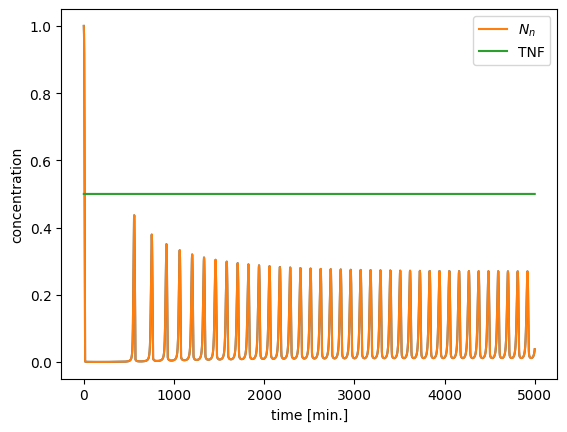

In [667]:
# plotting simulation
plt.plot(simulation["t"], simulation["y"][0])
plt.plot(t_trans, N_n_trans, label='$N_n$')
# plt.plot(t_trans, I_m_trans, label='$I_M$')
# plt.plot(t_trans, I_trans, label='I')
# plt.plot(t_trans, IKK_a_trans, label='$IKK_a$')
# plt.plot(t_trans, IKK_i_trans, label='$IKK_i$')
plt.plot(t_trans, TNF_k*np.ones(len(t_trans)), label='TNF')
plt.xlabel('time [min.]')
plt.ylabel('concentration')
plt.legend();

In [668]:
# function to compute stats for NFkB transient to find period and amplitude for TNF oscillation
def compute_int_oscillator(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # keep the last 10 peaks
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[-12:-2]
        stable_troughs = y_troughs[-11:-1]
    else:
        stable_peaks = y_peaks[-11:-1]
        stable_troughs = y_troughs[-12:-2]
        
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [669]:
# calcullating simulation stats
T_int, A_int, mean_int, stable_peaks_int, stable_troughs_int = compute_int_oscillator(t_trans, N_n_trans)

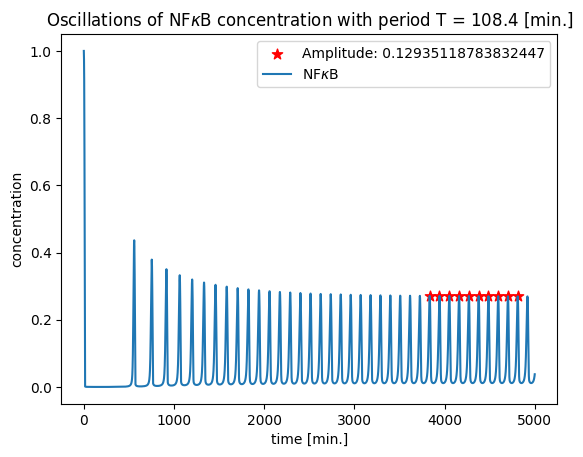

In [670]:
# plotting the chosen peaks (shouldn't they have the same amplitude?)
plt.scatter(t_trans[stable_peaks_int], N_n_trans[stable_peaks_int], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")
plt.plot(t_trans[-10000:], N_n_trans[-10000:], label='NF$\kappa$B')
plt.title(f"Oscillations of NF$\kappa$B concentration with period T = {T_int:.4} [min.]")
plt.xlabel('time [min.]')
plt.ylabel('concentration')
plt.legend();


In [671]:
# defining function to oscillate TNF (square wave)
def TNF_square_osc(oscillations, T_int, Amp, OOmega, N_n0, I_m0, I0, IKK_a0, IKK_i0):

    # calcullating the period of TNF in order to simulate with the desired ratio of ecternal over internal period
    T_ext = OOmega * T_int
    omega = T_int / T_ext

    TNF0 = k + Amp

    history = {"t":[] ,"N_n": [], "I_m": [], "I": [], "IKK_a":[], "IKK_i":[], "TNF":[]}

    # changing the value of TNF every half period
    for i in tqdm(range(oscillations*2)):
        if i == 0:
            state = N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF0
            sys = solve_ivp(system_nfkb, (0, T_ext/2), state, method='RK45', max_step=0.01, dense_output=True)
            t, N_n, I_m, I, IKK_a, IKK_i = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["N_n"].extend(N_n)
            history["I_m"].extend(I_m)
            history["I"].extend(I)
            history["IKK_a"].extend(IKK_a)
            history["IKK_i"].extend(IKK_i)
            history["TNF"].extend(np.ones(len(t))*TNF0)

        TNF_i = - history["TNF"][-1] + 2*k
        state = history["N_n"][-1], history["I_m"][-1], history["I"][-1], history["IKK_a"][-1], history["IKK_i"][-1], TNF_i
        t, N_n, I_m, I, IKK_a, IKK_i = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        sys = solve_ivp(system_nfkb, (0, T_ext/2), state, method='RK45', max_step=0.01, dense_output=True)
        history["t"].extend(t + history["t"][-1])
        history["N_n"].extend(N_n)
        history["I_m"].extend(I_m)
        history["I"].extend(I)
        history["IKK_a"].extend(IKK_a)
        history["IKK_i"].extend(IKK_i)
        history["TNF"].extend(np.ones(len(t))*TNF_i)
    return history, omega, T_ext

In [672]:
# defining omega, number of oscillations, amplitude, TNF_0 and start parameters as the last values of the first simulation
omega = 1
no_osc = 30
Amp1 = 0.1
p0 = [N_n_trans[-1], I_m_trans[-1], I_trans[-1], IKK_a_trans[-1], IKK_i_trans[-1]]

In [673]:
# simulating system with square TNF oscillations
TNF_sim1, ome, T_TNF = TNF_square_osc(no_osc, T_int, Amp1, omega, *p0)

100%|██████████| 60/60 [00:56<00:00,  1.07it/s]


In [674]:
# unpacking
t1, N_n1, I_m1, I1, IKK_a1, IKK_i1, TNF1 = np.array(TNF_sim1["t"]), np.array(TNF_sim1["N_n"]), np.array(TNF_sim1["I_m"]), np.array(TNF_sim1["I"]), np.array(TNF_sim1["IKK_a"]), np.array(TNF_sim1["IKK_i"]), np.array(TNF_sim1["TNF"])

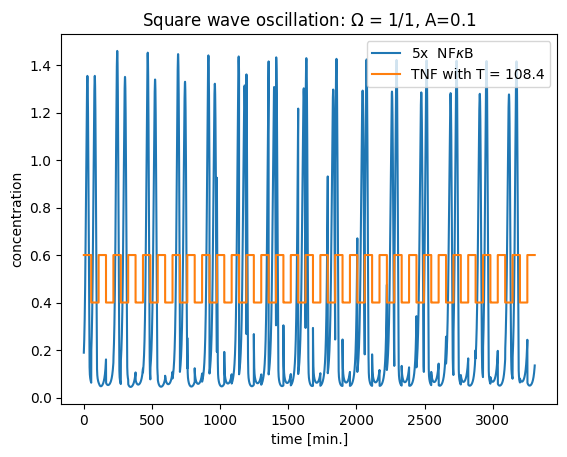

In [675]:
# plotting like the article
x = 5
plt.plot(t1, x*N_n1, label=f'{x}x  NF$\kappa$B')
plt.plot(t1, TNF1, label=f'TNF with T = {T_TNF:.4}')
plt.title(rf'Square wave oscillation: $\Omega$ = {round(omega)}/1, A={A}')
plt.xlabel('time [min.]')
plt.ylabel('concentration')
plt.legend();


In [676]:
# defining function to oscillate TNF (sinusoidal)
def TNF_sin_osc(oscillations, T_int, Amp, OOmega, N_n0, I_m0, I0, IKK_a0, IKK_i0):

    # calcullating the period of TNF in order to simulate with the desired ratio of ecternal over internal period
    T_ext = OOmega * T_int
    omega = T_int / T_ext

    TNF0 = k

    # defining how many intervals we are going to divide the period in
    l = 500

    history = {"t":[] ,"N_n": [], "I_m": [], "I": [], "IKK_a":[], "IKK_i":[], "TNF":[]}

    # changing the value of TNF sinusoidal for every period interval 
    for i in tqdm(range(oscillations*l)):
        if i == 0:
            state = N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF0
            sys = solve_ivp(system_nfkb, (0, T_ext/l), state, method='RK45', max_step=5, dense_output=True)
            t, N_n, I_m, I, IKK_a, IKK_i = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["N_n"].extend(N_n)
            history["I_m"].extend(I_m)
            history["I"].extend(I)
            history["IKK_a"].extend(IKK_a)
            history["IKK_i"].extend(IKK_i)
            history["TNF"].extend(np.ones(len(t))*TNF0)

        TNF_i = k + Amp * np.sin( np.pi * (1/T_ext) * history["t"][-1]) #should it be 2 times pi? In that case the period isn't right
        state = history["N_n"][-1], history["I_m"][-1], history["I"][-1], history["IKK_a"][-1], history["IKK_i"][-1], TNF_i
        t, N_n, I_m, I, IKK_a, IKK_i = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        sys = solve_ivp(system_nfkb, (0, T_ext/l), state, method='RK45', max_step=5, dense_output=True)
        history["t"].extend(t + history["t"][-1])
        history["N_n"].extend(N_n)
        history["I_m"].extend(I_m)
        history["I"].extend(I)
        history["IKK_a"].extend(IKK_a)
        history["IKK_i"].extend(IKK_i)
        history["TNF"].extend(np.ones(len(t))*TNF_i)
    return history, omega, T_ext

In [686]:
# simulating system with sinus oscillations
TNF_sim2, ome, T_TNF2 = TNF_sin_osc(no_osc, T_int, Amp1, omega, *p0)

  1%|          | 114/15000 [00:00<00:13, 1133.17it/s]

100%|██████████| 15000/15000 [00:08<00:00, 1813.19it/s]


In [687]:
# unpacking
t2, N_n2, I_m2, I2, IKK_a2, IKK_i2, TNF2 = np.array(TNF_sim2["t"]), np.array(TNF_sim2["N_n"]), np.array(TNF_sim2["I_m"]), np.array(TNF_sim2["I"]), np.array(TNF_sim2["IKK_a"]), np.array(TNF_sim2["IKK_i"]), np.array(TNF_sim2["TNF"])

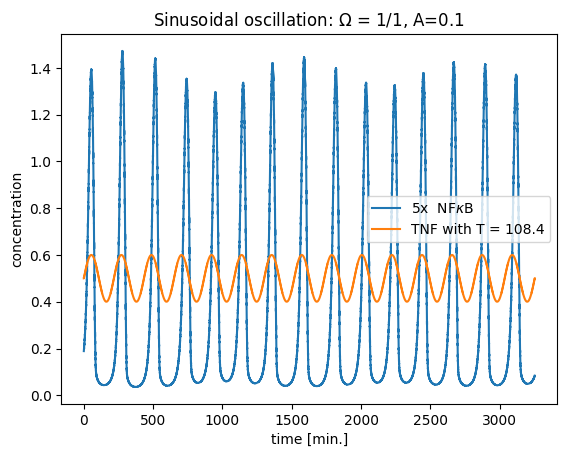

In [688]:
x = 5
plt.plot(t2, x*N_n2, label = f'{x}x  NF$\kappa$B')
plt.plot(t2, TNF2, label = f'TNF with T = {T_TNF:.4}')
plt.title(rf'Sinusoidal oscillation: $\Omega$ = {round(omega)}/1, A={Amp1}')
plt.xlabel('time [min.]')
plt.ylabel('concentration')
plt.legend();

In [698]:
# why does the amplitude og NFKB keep changing?
def multi_amplitude_plot(A_min, A_max, stepsize):
    
    Amp_arr = np.linspace(A_min, A_max, stepsize)

    figure, axis = plt.subplots(stepsize, figsize=[10,40])

    x = 5

    for i in tqdm(range(stepsize)):
        TNF_simi, ome, T_TNFi = TNF_sin_osc(no_osc, T_int, Amp_arr[i], omega, *p0)
        ti, N_ni, I_mi, Ii, IKK_ai, IKK_ii, TNFi = np.array(TNF_simi["t"]), np.array(TNF_simi["N_n"]), np.array(TNF_simi["I_m"]), np.array(TNF_simi["I"]), np.array(TNF_simi["IKK_a"]), np.array(TNF_simi["IKK_i"]), np.array(TNF_simi["TNF"])
        axis[i].plot(ti, x*N_ni, label = f'{x}x  NF$\kappa$B')
        axis[i].plot(ti, TNFi, label = f'TNF with T = {T_TNF:.4}, A = {Amp_arr[i]}')
        axis[i].set_title(rf'Sinusoidal oscillation: A={round(Amp_arr[i],2)}')
        axis[i].legend();  

    for ax in axis.flat:
        ax.set(xlabel='time [min.]', ylabel='concentration')
    for ax in axis.flat:
        ax.label_outer()

    figure.suptitle(f'Plot of sinusoidal external oscillation with amplitude ranging from {A_min} to {A_max}, $\Omega=1/1$')
    plt.tight_layout()

In [699]:
A_min = 0.3
A_max = 0.46
stepsize = 10

multi_amplitude_plot(A_min, A_max, stepsize)

100%|██████████| 10/10 [01:51<00:00, 11.12s/it]


ValueError: 
\Omgea=1/1
^
ParseFatalException: Unknown symbol: \Omgea, found '\'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x10ab9ad40> (for post_execute):


ValueError: 
\Omgea=1/1
^
ParseFatalException: Unknown symbol: \Omgea, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\Omgea=1/1
^
ParseFatalException: Unknown symbol: \Omgea, found '\'  (at char 0), (line:1, col:1)

<Figure size 1000x4000 with 10 Axes>